## In this notebook, we assign frame properties to candidates detected in the previous step.

**Necessary files:**
 - event_df (event specific dataframe with cleaned text)
 - frame_properties (dictionary with frames and their related keywords)
 - event_tagged_tweets (annotated tweets using stanza library)
 - model (word2vec model trained on event specific data (or the entire set))
 - cands (dataframe with tagged candidates, their heads, sets of phrases heads and cand_types) 
 - merged_dict (dictionary with merged candidates)
 

In [26]:
from nltk.corpus import stopwords
from collections import defaultdict
import nltk
import os
import pickle
import stanza
import pandas as pd

nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

tigray_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_tigray_clean.csv" # location of Tigray dataset
greece_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_greece_clean.csv" # location of Greece dataset
rohingya_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_rohingya_clean.csv" # location of Rohingya dataset
channel_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_channel_clean.csv" # location of Channel dataset

def pickle_file(file_name, file_to_dump):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path +  fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path + fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)
    
def read_event_df(data_url):
    directory_path = os.getcwd() + "/../../../../" + data_url 
    event_df = pd.read_csv(directory_path, index_col=0)
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} tweets!')
    return event_df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikodemicek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Creating word frame properties dictionary

In [ ]:
#load word2vec model
model = 

In [115]:
# run this if  [event]_word_properties does not exist yet

def assign_word_frame_properties(tweets_corpus):
    print('assigning frame properties to words from tweets...')
    word_properties = defaultdict(dict)
    for i in tqdm(tweets_corpus):
        tweet_words = [word.lower() for word in i.split() if word not in stop_words and len(word)>1]
        for word in tweet_words:
            #print(word)
            word = lemma.lemmatize(word)
            property_list = []
            #print(list(frame_properties.keys()))
            for prop in list(frame_properties.keys()):
                #print(frame_properties[prop])

                try:
                    #print(f'sim of {word}, {prop} is {model.similarity(word, prop)}')
                    weights = [model.similarity(word, seed) for seed in frame_properties[prop]]
                    #print(weights)
                    if max(weights)>0.4:
                        word_properties[word][prop] = max(weights)
                except KeyError:
                    pass
    return  word_properties            

            

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikodemicek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|                                                                                        | 0/92806 [00:00<?, ?it/s]

preprocessing tweets...
assigning frame properties to words from tweets...


100%|████████████████████████████████████████████████████████████████████████████| 92806/92806 [51:55<00:00, 29.79it/s]

defaultdict(<class 'dict'>, {'racism': {'no trustworthiness': 0.45143962}, 'hate': {'affection': 0.6003957}, 'thousand': {'economisation': 1.0}, 'refugee': {'reception': 0.60989624}, 'dozen': {'economisation': 0.47637963}, 'asylum': {'reception': 1.0}, 'homeless': {'settlement': 0.57510066}, 'accommodation': {'settlement': 0.8532543}, 'protest': {'humanitarian': 0.40294492}, 'camp': {'settlement': 1.0}, 'want': {'affection': 0.43143085}, 'shelter': {'settlement': 1.0}, 'dead': {'victimization': 1.0}, 'why': {'reason': 0.61324227}, 'help': {'humanitarian': 1.0}, 'chief': {'criminality': 0.622512}, 'support': {'humanitarian': 1.0}, 'illegal': {'criminality': 0.45195127}, 'arrest': {'criminality': 0.5394254}, 'displaced': {'settlement': 0.47044814}, 'country': {'victimization': 0.43598586}, 'man': {'criminality': 0.5247485, 'victimization': 0.52303016}, 'racist': {'dishonor': 0.4069227}, 'excuse': {'reason': 0.60485476}, 'police': {'criminality': 1.0}, 'unaccounted': {'victimization': 0.4

In [117]:
pickle_file('moria_word_properties',word_properties)

## Get dependent words for entities

In [8]:
event_df = read_event_df(greece_url)
tagged_tweets = load_pickle('greece_tagged_tweets')
what_merged = load_pickle('greece_what_merged')


In [23]:
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
def get_ent_head(entity):
    if len(word_tokenize(entity))>1:
        entity_doc = en_nlp(entity)
        #the root of NP has value 0. Since head is only one and stored in a list, we pick item [0]
        return [word.text for tweet_ent in entity_doc.sentences for word in tweet_ent.words if word.head == 0][0]
    else:
        return entity


en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [88]:
def find_biased_words(entity):
        rep_head = lemma.lemmatize(entity.lower())
        #add bias by word choice
        #print(entity,rep_head)
        frame_devices.append(rep_head) 
        if rep_head in tagged_tweets[tweet_id].text.lower() and len(rep_head)>1:
            #find all dependencies of the phrase head
            for related in range(len(ent_words)):
                ent_word_lemma = lemma.lemmatize(ent_words[related][1].lower())
                #print(f'Yes it is, related = {lemma.lentemmatize(cand_heads[related][1].lower(),pos=NOUN)}')
                if rep_head == ent_word_lemma:
                    related_word = lemma.lemmatize(ent_words[ent_words[related][2]-1][1].lower())
                    #add bias by labeling
                    frame_devices.append(related_word) 

#for entity in tqdm(what_merged.keys()):
entity = 'germany'
frame_devices=[]
ent_head = get_ent_head(entity)
for tweet_id in tqdm(event_df.index): 
    if entity in tagged_tweets[tweet_id].text.lower():
        ent_words = [[word.id, word.text,word.head] for sent in tagged_tweets[tweet_id].sentences for word in sent.words]
        find_biased_words(entity)
        #print(tagged_tweets[tweet_id].text.lower())
    #print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in tagged_tweets[tweet_id].sentences for word in sent.words], sep='\n')
    #print(len(cand_df['candidates']))
#print(ent_head)

  0%|          | 0/137462 [00:00<?, ?it/s]

In [92]:
import nltk
from nltk.corpus import stopwords
#print(stopwords.words('english'))

ne_list1 = str.split("refugee migrant eu uk immigrant seeker abiy addis aegean afewerki afeworki afghan afghanistan africa african america amnesty ahmed american amhara andrew ankara antony arab asean asia assad aung bachelet balukhali bangladesh bangladeshi biden blinken boris borisjohnson borrell brexit brit britain british brussels bulgaria burma burmese calais canada channel china commission commissioner corona coronavirus council covid cox dover dublin edirne england english erdoan erdogan eritrea eritrean ethiopia ethiopian euro europe european evros farage filippo fontelles france french freya_cole garneau geneva german germany grandi greece greek guterres haavisto hamdayet harris hindu hitsats houthi houthis idlib idp india indian iran iraq isaias isayas isi israel italy jammu jazeera jerry johnson josep junta justin kachin kadra karen kayin kamala kent kenya kurd labour linda lindat_g lebanon lesbos lesvos libya london maikadra manipur marc merkel michelle mizoram moria muslim mutraw myanmar nation nations nationshumanrights nato nazi nigel november oromia oromo pakistan patel president priti putin reuters rohingya rohingyas russia russian samri secretary shimelba shire somalia spain state sudan sudanese syria syrian tegaru tigrai tigrayan tigrayans thai thailand tory tplf trudeau trump turk turkey turkish unhcr unicef union united unsc us yemen youtube"," ")
ne_list2 = str.split("able absolutely access according account accountable across action actually affected agency agree agreement alive allegation allow allowed allowing almost alone along already also always ambassador amid among another answer anti anymore anyone anything area arent around arrived article asylum attempt attention away back based basic become believe best better black blame blocked born breaking bring brother build call called calling came cant case caught cause centre change claim claiming clear clearly close come coming comment commited commiting completely concern concerned condemn condition confirmed  continue continues could country course cover created credible crisis currently daily day deal dear decade decision demand department despite didnt difference different dire doesnt done dont east eastern easy either effort else endf enough especially ethnic even ever every everyone everything evidence evil exactly expect extremely face facility facing fact failed fake false federal feel find first found four forget free fuck fucking full genuine getting given giving great ground group happy imagine including issue instead isnt give going good half hand happen happened happening hard head heading held high horn hour however huge idea image immediate immediately independent information inside internal internally interview investigate investigation issue join journalist keep kind know known lack land landing largest last latest leader least left let letting level lie like likely little live living load local long longer look looking lost made mail major majority make making many massive matter maybe mean medium member middle might migration mind month morning mostly move much must name national near nearly need needed neighboring never news next nobody north northern nothing obviously office official one ongoing operation others paid part party pas past people perhaps person place plan please point post press prevails prime probably problem process programme provide public push putting question quite rather reach read real realise reality really reason received recent record remains remember report reported reporting resident response responsible rest result right said satellite say saying second seek seeker seeking seem seems seen send sending sent series service several shame share shit show side simple simply since single site situation small someone something soon sorry sort south source speak special spread stand star start started statement street still stop stopped stopping story stupid sure surely system take taken taking talk talking tell term testimony thank thanks thats there theyre thing think though thought three time today told took torn towards town tried true truth trying turn tweet understand unless urgent urgently used using video vice view virus visit voice wait waiting want wanted watch water week welcome well west western withdraw within without whats whilst white whole wing wish wonder wont word world worse wrong would year yesterday young youre"," ")
ne_list = ne_list1 + ne_list2 + stopwords.words('english')

In [93]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                stopwords = ne_list,
                min_font_size = 10).generate(" ".join(frame_devices))

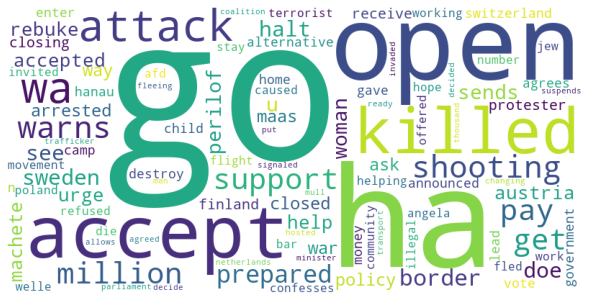

In [94]:
import matplotlib.pyplot as plt

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Assign frame properties 

In [ ]:
tagged_tweets = load_pickle('greece_tagged_tweets')
word_properties

In [51]:
def assign_frame_properties(event_df, tagged_tweets,cands):
    # import these modules 
    from collections import defaultdict
    from nltk.stem import WordNetLemmatizer 
    from nltk.corpus.reader.wordnet import NOUN
    import numpy as np    
    
    def find_biased_words(cand):
        rep_head = lemma.lemmatize(cand[1].lower(),pos=NOUN)
        #add bias by word choice
        add_dataframe_entry(cand,rep_head)
        if rep_head in tagged_tweets[tweet_id].text.lower() and len(rep_head)>1:
            #find all dependencies of the phrase head
            for related in range(len(cand_words)):
                cand_word_lemma = lemma.lemmatize(cand_words[related][1].lower())
                #print(f'Yes it is, related = {lemma.lemmatize(cand_heads[related][1].lower(),pos=NOUN)}')
                if rep_head == cand_word_lemma:
                    related_word = lemma.lemmatize(cand_words[cand_words[related][2]-1][1].lower())
                    #add bias by labeling
                    add_dataframe_entry(cand,related_word) 
    
    def add_dataframe_entry(cand,biased_word):
        cand_frames['word'].append(cand[0])
        cand_frames['date'].append(event_df['date'][tweet_id])
        #cand_frames['word'].append(phrase_head)
        for frame_property in list(frame_properties.keys()):
            #print(frame_property)
            try:
                #print(word_properties[phrase_head][frame_property])
                cand_frames[frame_property].append(word_properties[biased_word][frame_property])
            except KeyError:
                #cand_frames[frame_property].append(word_properties['tent'][frame_property])
                cand_frames[frame_property].append(np.NaN)
                
 
                        
    lemma = WordNetLemmatizer() 
    cand_frames = defaultdict(list)

    framed_words = pd.DataFrame(columns=['word','date',list(frame_properties.keys())])
    event_df[['date','time']] = event_df['created_at'].str.split(' ',expand=True)

    for tweet_id in tqdm(event_df.index):
        
        cand_words = [[word.id, word.text,word.head] for sent in tagged_tweets[tweet_id].sentences for word in sent.words]
        #print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in tagged_tweets[tweet_id].sentences for word in sent.words], sep='\n')
        #print(len(cand_df['candidates']))
        for cand in cands['candidates']:
            """ THIS IS AN IMPORTANT PART, IT HANDLES ASSIGNING BIAS FOR MERGED CANDIDATES
            logic:  first check if the entire candidate is in the tweet. If yes, add bias of its head and all labels.
             Then do the same for every candidate that was merged into the main candidate.
             If the main candidate is not in the tweet, check each candidate that was merged into it.
             If neither the main, nor its merged candidates are in the tweet, use the head of the main candidate only"""
            if cand[0].lower() in tagged_tweets[tweet_id].text.lower() and len(cand[0])>1:
                find_biased_words(cand)
                try:
                    for merged_cand in merged_dict[cand[0].lower()]:
                        if merged_cand[0].lower() in tagged_tweets[tweet_id].text.lower() and len(merged_cand[0])>1:
                            find_biased_words(merged_cand)
                except KeyError:
                    pass

            if cand[0].lower() not in tagged_tweets[tweet_id].text.lower():
                try:
                    for merged_cand in merged_dict[cand[0].lower()]:
                        if merged_cand[0].lower() in tagged_tweets[tweet_id].text.lower() and len(merged_cand[0])>1:
                            find_biased_words(merged_cand)
                except KeyError:
                    pass
            else:
                find_biased_words(cand)
    
    return cand_frames


cand_frames = assign_frame_properties(event_df,tagged_tweets,event_cands_merged)


    
                
        

100%|██████████████████████████████████████████████████████████████████████████| 92806/92806 [1:22:16<00:00, 18.80it/s]


In [19]:
#print(cand_frames.keys())
framed_words = pd.DataFrame.from_dict(cand_frames)

#framed_words[framed_words['word']=='migrants'].tail(50)

#framed_words = framed_words.dropna(subset=['settlement', 'reception', 'security', 'criminality', 'economisation', 'humanitarian', 'victimization', 'integration', 'affection', 'refusal', 'trustworthiness', 'no trustworthiness', 'reason', 'unreason/irrationality', 'easiness', 'difficulty', 'honor', 'dishonor'],how='all')

framed_words

,word,date,settlement,reception,security,criminality,economisation,humanitarian,victimization,integration,affection,refusal,trustworthiness,no trustworthiness,reason,irrationality,easiness,difficulty,honor,dishonor
0,fire,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fire,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fire,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fire,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fire,2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070703,CA,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6070704,NC,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6070705,NC,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6070706,NY,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
framed_words['word'].value_counts().nlargest(100)

And        205456
GR         147800
Greece     146876
He         144550
fire       139706
            ...  
Germany     13086
the EU      13038
MPs         12964
need        12818
war         12764
Name: word, Length: 100, dtype: int64

In [348]:
the_word = 'refugee'

def aggregate_frames(framed_words):
    merged_frames = framed_words.copy()

    #framed_words[framed_words['date']=='2020-09-04']

    merged_frames['no trustworthiness'] = - merged_frames['no trustworthiness']
    merged_frames['refusal'] = - merged_frames['refusal']
    merged_frames['irrationality'] = -merged_frames['irrationality']
    merged_frames['difficulty'] = -merged_frames['difficulty'] 
    merged_frames['dishonor'] = -merged_frames['dishonor']


    trust = ['trustworthiness', 'no trustworthiness']
    honor = ['honor', 'dishonor']
    affection = ['affection','refusal']
    reason = ['reason','irrationality']
    easiness = ['easiness','difficulty']

    merged_frames = pd.lreshape(merged_frames,
                            {'reason':reason, 'honor':honor,'affection':affection,'trust':trust,'easiness':easiness},
                           dropna=False)


    merged_frames = merged_frames[merged_frames['word'] == the_word]
    
    merged_frames['week'] = pd.to_datetime(merged_frames['date'], format='%Y-%m-%d').dt.strftime('%W')
    #aggr_frames = merged_frames.groupby(['word','week'],as_index=False).mean()
    aggr_frames = merged_frames.groupby(['word'],as_index=False).mean()
    frame_size = merged_frames.groupby(['word','week'],as_index=False).size()

    return aggr_frames,frame_size

aggr_frames,_ = aggregate_frames(framed_words)
aggr_frames0,size0 = aggregate_frames(framed_words0)
aggr_frames1,size1 = aggregate_frames(framed_words1)
aggr_frames2,size2 = aggregate_frames(framed_words2)
aggr_frames3,size3 = aggregate_frames(framed_words3)
aggr_frames4,size4 = aggregate_frames(framed_words4)
aggr_frames5,size5 = aggregate_frames(framed_words5)
#aggr_frames6 = aggregate_frames(framed_words6)
aggr_frames

af = pd.concat([aggr_frames0,aggr_frames1,aggr_frames2,aggr_frames3,aggr_frames4,aggr_frames5])
af

,word,criminality,economisation,humanitarian,integration,reception,security,settlement,victimization,reason,honor,affection,trust,easiness
0,refugee,0.538906,0.868006,0.714931,NaN,0.609365,0.684697,0.970225,0.552637,0.489588,0.200376,-0.148064,-0.222400,-0.733090
0,refugee,0.473278,0.846614,0.697133,NaN,0.609725,0.540466,0.974121,0.543286,0.505104,0.167807,-0.151933,-0.237938,-0.596747
0,refugee,0.587951,0.862315,0.706727,NaN,0.609358,0.623774,0.977574,0.538553,0.555089,0.087064,-0.137056,-0.290872,-0.469395
0,refugee,0.542529,0.931133,0.719745,NaN,0.608951,0.722851,0.980443,0.566759,0.497186,-0.010324,-0.084682,-0.247231,-0.607755
0,refugee,0.512998,0.740236,0.694875,NaN,0.609102,0.654367,0.935843,0.551111,0.475116,-0.012453,-0.070148,-0.184379,-0.590338
0,refugee,0.602713,0.908098,0.685298,NaN,0.608965,1.000000,0.987103,0.578020,0.516141,0.005731,-0.212431,-0.467955,-0.650921


In [338]:
aggr_frames.columns[2:]

Index(['criminality', 'economisation', 'humanitarian', 'integration',
       'reception', 'security', 'settlement', 'victimization', 'reason',
       'honor', 'affection', 'trust', 'easiness'],
      dtype='object')

In [ ]:
fig = px.bar(data_canada, x='year', y='pop')
fig.show()

In [307]:
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

frame = 'easiness'

ax1 = px.line(aggr_frames0, x="week", y=[frame],render_mode='webgl')
ax2 = px.line(aggr_frames1,x="week", y=[frame],render_mode='webgl')
ax3 = px.line(aggr_frames2,x="week", y=[frame],render_mode='webgl')
ax4 = px.line(aggr_frames3,x="week", y=[frame],render_mode='webgl')
ax5 = px.line(aggr_frames4,x="week", y=[frame],render_mode='webgl')
ax6 = px.line(aggr_frames5,x="week", y=[frame],render_mode='webgl')

#ax2 = px.line(frame_size, x="date", y=['size'],render_mode='webgl')

#ax2.update_traces(yaxis='y2')
fig.add_traces(ax1.data + ax2.data + ax3.data + ax3.data + ax5.data + ax6.data)

fig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))

fig.show()

KeyError: 'variable'

In [ ]:
import plotly.express as px
for frame in aggr_frames.columns[2:]:
    print(frame)
    try:
        fig = px.line(aggr_frames, x="week", y=[frame], title=f'Frame bias towards {the_word}')
        fig.show()
    except ValueError:
        pass

# TESTING:

In [ ]:


for tweet in tqdm(range(len(tweets_corpus))):
    print(tweets_corpus[tweet])
    np_heads = [[word.id, word.text,word.head,word.deprel] for sent in tagged_tweets[tweet].sentences for word in sent.words]
    print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in tagged_tweets[tweet].sentences for word in sent.words], sep='\n')
    #print(np_heads)
    ph_ids = set([np_heads[i][2] for i in range(len(np_heads))])
    ph_words = [np_heads[i-1][1] for i in ph_ids]

    word_pairs = [(np_heads[word][1], np_heads[np_heads[word][2]-1][1]) for word in range(len(np_heads)) if np_heads[word][2] != 0]
    #print(word_pairs)
    
    compounds = [[np_heads[i][1]+'_'+np_heads[np_heads[i][2]-1][1]] for i in range(len(np_heads)) if 'compound' in np_heads[i][3]]
    print(compounds)
    
    advmods = [[np_heads[i][1]+'_'+np_heads[np_heads[i][2]-1][1]] for i in range(len(np_heads)) if np_heads[i][3]=='advmod']
    print(advmods)
    
    amods = [[np_heads[i][1]+'_'+np_heads[np_heads[i][2]-1][1]] for i in range(len(np_heads)) if np_heads[i][3]=='amod']
    print(amods)
    for pair in word_pairs:
        phrase = pair[0]+'_'+pair[1]

    #print(model.most_similar('illegal_immigrant'))

    
    """#print(len(cand_df['candidates']))
    candidate_list = cand_df['candidates']
    for cand in cand_df['candidates']:
        #print(cand[2])
        #print(get_head(str(cand)))
        for phrase_head in cand[2]:
            #print(phrase_head)
            #if str(cand[1]) in str(tweet):
            if str(phrase_head) in str(tweet) and len(phrase_head)>2:
                #print(phrase_head)
                ph_words = [np_heads[i-1][1] for i in phrase_heads]
                #print(ph_words)
                for related in range(len(np_heads)):
                    if phrase_head == np_heads[related][1]:
                        pass
                        #print(f'checking {phrase_head}_{np_heads[np_heads[related][2]-1][1]}')
                  for frame_property in list(frame_properties.keys()):
                        for seed_word in frame_properties[frame_property]:
                        try:
                            for related in range(len(np_heads)):
                                #print(np_heads[related])
                                #if cand[1] == np_heads[related][1]:
                                if phrase_head == np_heads[related][1]:
                                    print(f'checking {seed_word} and {phrase_head}_{np_heads[np_heads[related][2]-1][1]}')
                                    #cand_frames[seed_word][phrase_head].append(model.similarity(seed_word,np_heads[np_heads[related][2]-1][1]))
                                #[cand_frames[seed_word][cand].append(model.similarity(seed_word,np_heads[np_heads[related][2]+1][1])) if cand == np_heads[related][1] else print('') for related in range(len(np_heads))]
                                except KeyError:
                                pass"""